In [105]:
#Importing libraries and the visitor log obtained from gym owners.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import patches as patches
from matplotlib.dates import DateFormatter
import seaborn as sns
sns.set_style('darkgrid')
from datetime import date, timedelta, datetime,time
import os
occupant_log = pd.read_csv('../input/occupant-log/occupant_log.csv')
visitor_log = pd.read_csv('../input/visitor-log/visitor_log.csv')

In [106]:
#Checking what the visitor log looks like
visitor_log.head(10)

,Visit Date,Visit Time,Member ID,Membership Name,Entry Access
0,2017-01-01,10:52:53,5206.0,Regular Monthly Membership,Successful
1,2017-01-01,10:52:53,5206.0,Regular Monthly Membership,Successful
2,2017-01-02,6:51:34,5048.0,Regular Monthly Membership,Successful
3,2017-01-02,6:51:34,5048.0,Regular Monthly Membership,Successful
4,2017-01-02,7:02:27,5071.0,Regular Monthly Membership,Successful
5,2017-01-02,7:02:28,5071.0,NaN,Successful
6,2017-01-03,17:57:42,NaN,NaN,Denied: New Card
7,2017-01-03,5:22:08,5206.0,Regular Monthly Membership,Successful
8,2017-01-03,5:22:08,5206.0,Regular Monthly Membership,Successful
9,2017-01-03,16:24:22,5073.0,Regular Monthly Membership,Successful


So a few things I've noticed:
* I need to create a Timestamp column to use DateTime functions effectively. 
* I need to drop the *Denied* entries since members aren't actually getting in if they're denied access. 
* The *nan* membership names need to be dropped as well, it looks like there's an error in the system where it'll read another login a second later with a *nan* value.
* Finally, I'll add Weekday and Month columns for some visualization.


In [107]:
#Making a Timestamp index by combining the Date/Time columns
visitor_log['Timestamp'] = pd.to_datetime(visitor_log['Visit Date'] + ' ' + visitor_log['Visit Time'])
visitor_log.set_index(['Timestamp'])

#Adding the day of the week, and taking out the 'Denied' entries
visitor_log['Weekday'] = visitor_log.Timestamp.dt.day_name()
visitor_log = visitor_log[visitor_log['Entry Access'] == 'Successful']

#Converting the Membership Name column to strings
visitor_log['Membership Name'] = visitor_log['Membership Name'].astype(str)
visitor_log['Weekday'] = visitor_log['Weekday'].astype(str)

#Removing all NaN membership names
visitor_log = visitor_log[visitor_log['Membership Name'] != 'nan']

#Adding a Month column
visitor_log['Month'] = visitor_log.Timestamp.dt.month_name()

In [108]:
#Checking the data again
visitor_log.head(10)

,Visit Date,Visit Time,Member ID,Membership Name,Entry Access,Timestamp,Weekday,Month
0,2017-01-01,10:52:53,5206.0,Regular Monthly Membership,Successful,2017-01-01 10:52:53,Sunday,January
1,2017-01-01,10:52:53,5206.0,Regular Monthly Membership,Successful,2017-01-01 10:52:53,Sunday,January
2,2017-01-02,6:51:34,5048.0,Regular Monthly Membership,Successful,2017-01-02 06:51:34,Monday,January
3,2017-01-02,6:51:34,5048.0,Regular Monthly Membership,Successful,2017-01-02 06:51:34,Monday,January
4,2017-01-02,7:02:27,5071.0,Regular Monthly Membership,Successful,2017-01-02 07:02:27,Monday,January
7,2017-01-03,5:22:08,5206.0,Regular Monthly Membership,Successful,2017-01-03 05:22:08,Tuesday,January
8,2017-01-03,5:22:08,5206.0,Regular Monthly Membership,Successful,2017-01-03 05:22:08,Tuesday,January
9,2017-01-03,16:24:22,5073.0,Regular Monthly Membership,Successful,2017-01-03 16:24:22,Tuesday,January
10,2017-01-03,16:24:22,5073.0,Regular Monthly Membership,Successful,2017-01-03 16:24:22,Tuesday,January
11,2017-01-03,16:52:05,5069.0,1 Month Unlimited Membership - Student,Successful,2017-01-03 16:52:05,Tuesday,January


In [109]:
#Seeing how many different members have visited
visitor_log['Member ID'].nunique()

2286

In [110]:
#Seeing how many times the top members have been
top_members = visitor_log['Member ID'].value_counts()
top_members = top_members.iloc[0:10]
top_members

5073.0    744
5747.0    640
6496.0    479
5786.0    478
5391.0    469
6328.0    442
5842.0    434
5664.0    425
5736.0    423
7443.0    422
Name: Member ID, dtype: int64

In [124]:
#Seeing the Most Popular Membership Types
pop_members = visitor_log['Membership Name'].value_counts()
pop_members = pop_members.iloc[0:10]
pop_members

Regular Monthly Membership                                    25989
Student/Military Monthly Membership                           11935
Personal Training                                              7435
Family Monthly Membership - For Non-Master Accounts            4760
Family Monthly Membership                                      4124
10 days for $10!                                               4053
Industry Monthly Membership                                    2880
Island Health Employee (VIHA) - Regular Monthly Membership     2470
Comp Monthly Membership                                        2133
1 Year Kaiser Jiu Jitsu Membership                             1527
Name: Membership Name, dtype: int64

It's obvious that the *Regular Monthly Membership* is the most popular. Considering the amount of personal trainers are working in the gym it's not surprising people showing up for *Personal Training* is #3 on the list. Also it looks like the *10 days for $10* is a great promotion!

Now, I want to make a table that shows the total visitors per day. Then I can use that table to show data about each day of the week and each month.

In [112]:
#Creating the daily_visitors table that counts the visitors per day. Taking out all the other columns and just leaving the weekday name and month name.
daily_visitors = visitor_log.resample('D', on = 'Timestamp').count()
daily_visitors = daily_visitors.drop(columns = {'Visit Time', 'Member ID', 'Membership Name', 'Entry Access', 'Timestamp'})
daily_visitors = daily_visitors.rename(columns = {'Visit Date': 'Visitors'})
daily_visitors['Weekday'] = daily_visitors.index.day_name()
daily_visitors['Month'] = daily_visitors.index.month_name()
daily_visitors.head(10)

,Visitors,Weekday,Month
Timestamp,,,
2017-01-01,2,Sunday,January
2017-01-02,3,Monday,January
2017-01-03,7,Tuesday,January
2017-01-04,2,Wednesday,January
2017-01-05,6,Thursday,January
2017-01-06,3,Friday,January
2017-01-07,3,Saturday,January
2017-01-08,2,Sunday,January
2017-01-09,8,Monday,January


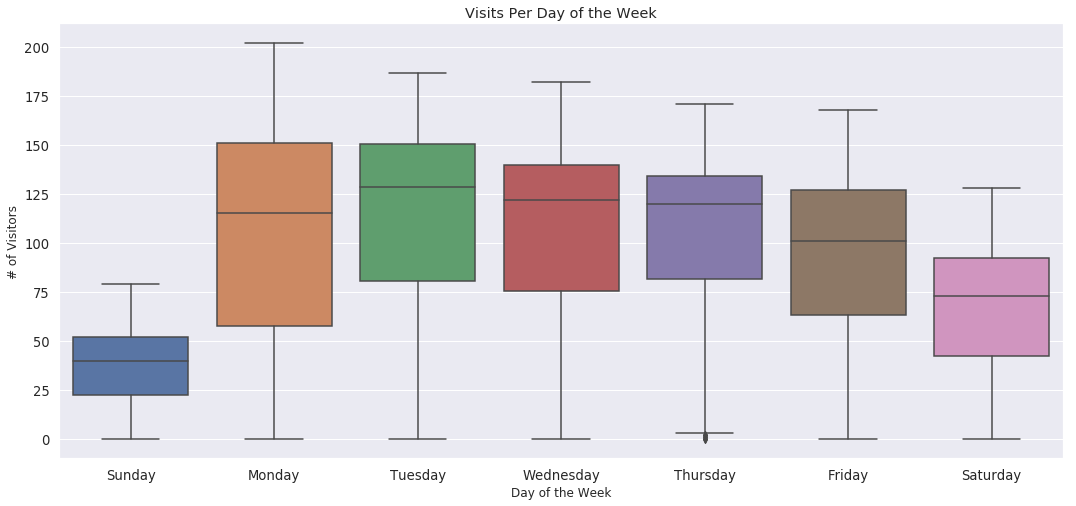

In [122]:
#Plotting Visits per Day of the Week
plt.figure(figsize=(18,8))
ax = sns.boxplot(x = 'Weekday', y ='Visitors', data = daily_visitors, saturation=0.75)
plt.title("Visits Per Day of the Week")
plt.ylabel('# of Visitors', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
plt.show()

Sunday is unsurprisingly the least busy day of the week, as it's part of the weekend, no classes run on Sunday's and it has the shortest open hours of the week.

Although Tuesday is on average the busiest day of the week, i'd be more inclined to think Monday may be busier per regular business day when you factor holidays into account. Holiday Monday's are typically empty and this brings down the total count.

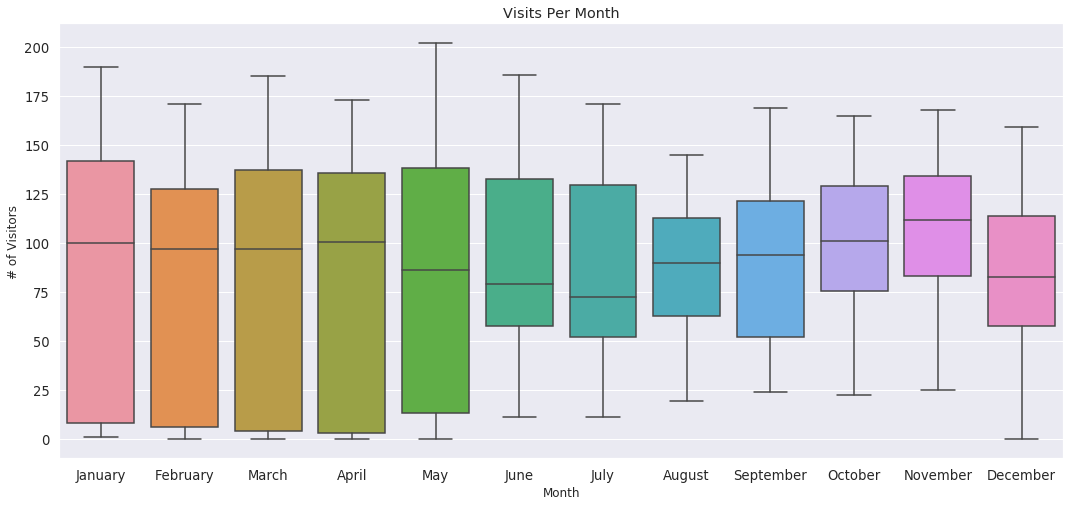

In [121]:
#Plotting Visits per Month
plt.figure(figsize=(18,8))
ax = sns.boxplot(x = 'Month', y ='Visitors', data = daily_visitors, saturation=0.75)
plt.title("Visits Per Month")
plt.ylabel('# of Visitors', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

I'm surpised May is the busiest month overall. I can only assume it's because summer is about to begin, so everyone's taking one last opportunity to get that beach body. January is very close behind which is expected, it's a popular new year's resolution to get back into the gym and start better habits.

July and August are the least busy months, being they're in the middle of summer that's no surprise. People are on vacation, outside, camping, etc. There's loads of activities to do outside. 

Finally, the month of December doesn't see many visitors. People (like me) tend to take a full week off from the gym when Christmas rolls around, and start back in the new year.

Now let's look at the occupant log obtained. This is a dataframe based on the visitor's log, that aggregates the amount of members present on each hour. The assumption made is that each member spends about 1.5 hours inside once signed in.

In [115]:
occupant_log.head(10)

,Unnamed: 0,Occupants,realtime,Date,Time,Day,Weekday,Month
0,1,0,2017-01-01 8:00,2017-01-01,8,1,6,1
1,2,0,2017-01-01 9:00,2017-01-01,9,1,6,1
2,3,0,2017-01-01 10:00,2017-01-01,10,1,6,1
3,4,2,2017-01-01 11:00,2017-01-01,11,1,6,1
4,5,2,2017-01-01 12:00,2017-01-01,12,1,6,1
5,6,0,2017-01-01 13:00,2017-01-01,13,1,6,1
6,7,0,2017-01-01 14:00,2017-01-01,14,1,6,1
7,8,0,2017-01-01 15:00,2017-01-01,15,1,6,1
8,9,0,2017-01-01 16:00,2017-01-01,16,1,6,1
9,10,0,2017-01-01 17:00,2017-01-01,17,1,6,1


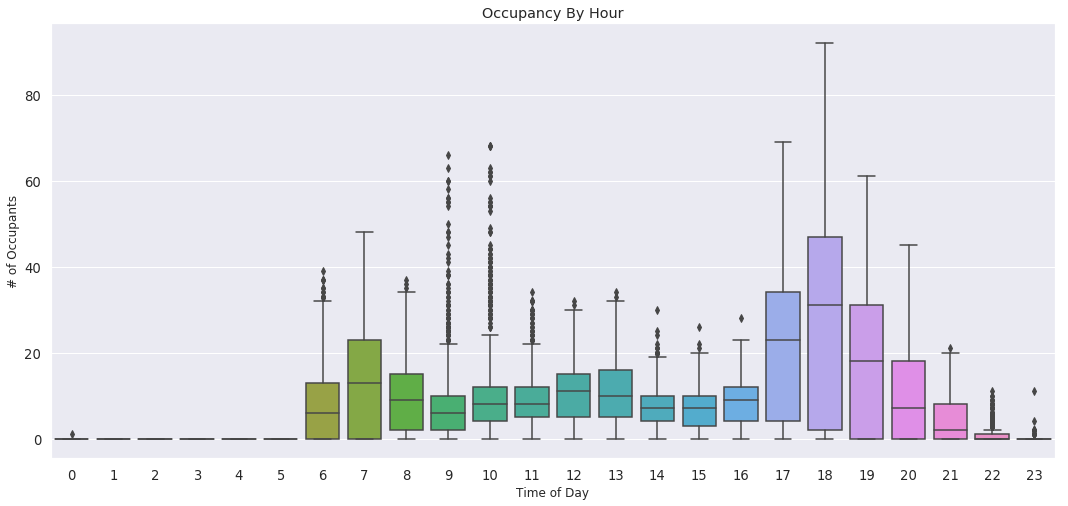

In [116]:
#Showing the Number of Occupants By Hour
plt.figure(figsize=(18,8))
ax = sns.boxplot(x ='Time', y ='Occupants', data = occupant_log, saturation=0.75)
plt.title("Occupancy By Hour")
plt.ylabel('# of Occupants', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)

plt.show()

Since the gym isn't open typically between 10:00PM and 5:00AM, let's adjust so we can read the data a little easier.

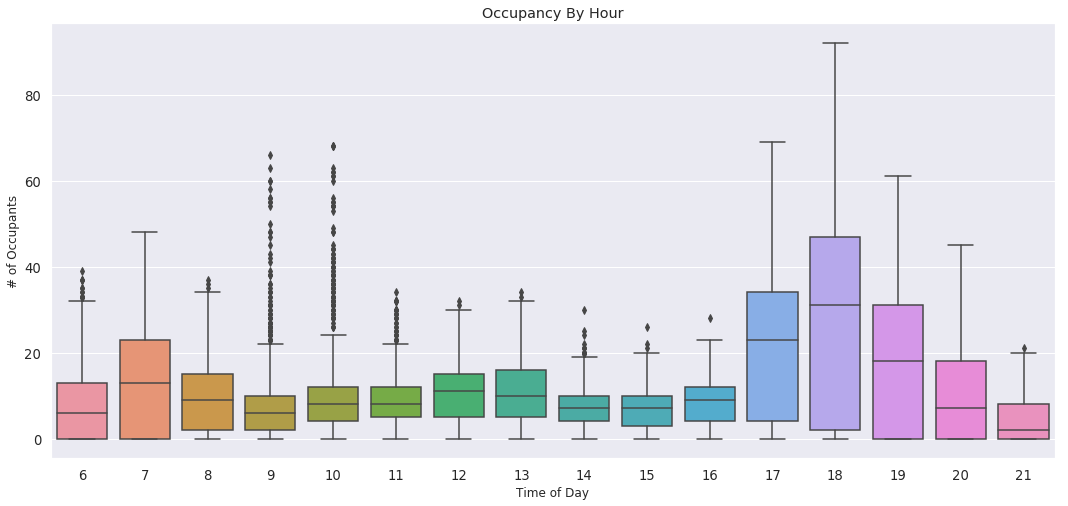

In [123]:
#Dropping Rows During Closing Hours
better_log = occupant_log.set_index('realtime')
better_log.drop(better_log[(better_log.Time <= 5) | (better_log.Time >= 22)].index, inplace=True)
better_log.drop(better_log[((better_log.Time <= 8) | (better_log.Time >= 17)) & (better_log.Weekday == 'Sunday')].index, inplace=True)
better_log.drop(better_log[((better_log.Time <= 9) | (better_log.Time >= 18)) & (better_log.Weekday == 'Saturday')].index, inplace=True)

#Showing the Number of Occupants By Hour (Removed Closed Time)
plt.figure(figsize=(18,8))
ax = sns.boxplot(x = 'Time', y = 'Occupants', data = better_log, saturation=0.75)
plt.title("Occupancy By Hour")
plt.ylabel('# of Occupants', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)

plt.show()

Apparently 6:00PM is the busiest time of the day, who knew! With everyone getting off work and classes running between 5-7PM it's unsurprising.

The 4 busiest hours seem to be 6:00PM, 5:00PM, 7:00PM and finally 7:00AM. The morning crowd is no joke, I've been during that time and it's still a good turnout.

The reason there's so many outliers for the 9-11:00AM times is because the gym is usually empty during those times on a weekday. But those are the busiest weekend times. So those times have lots of fluctuations.

It looks like if you want a guarunteed spot, 12:00PM-4:00PM is your best bet. Those times are rather consistent with fewer outliers than many other times.